# Overview
Since making all the predictions takes a long time and quite a bit of memory, we make a seperate kernel for just the submission, where we read the test data and apply the model. The model is built and trained in the kernel at https://www.kaggle.com/kmader/baseline-u-net-model-part-1


In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import h5py
import cv2
from tqdm import tqdm_notebook
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import binary_opening, disk
# from skimage.io import imread
from skimage.util import montage
from scipy import ndimage as ndi

import tensorflow as tf
from keras import backend as K
from keras.engine import InputLayer
from keras.models import load_model
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.layers import Input

from utils import get_datetime_now
from utils import get_best_model_name
from utils import rle_encode
from utils import rle_decode
from utils import rle_to_full_mask
from utils import multi_rle_encode

import gc; gc.enable() # memory is tight

_EPSILON = K.epsilon()

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

Using TensorFlow backend.


In [2]:
def focal_loss_wrapper(gamma=2., alpha=.25, axis=-1):
    def focal_loss(y_true, y_pred):
        y_pred_c = K.clip(y_pred, _EPSILON, 1.0 - _EPSILON)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred_c, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred_c, tf.zeros_like(y_pred))
        res1 =      alpha  * K.pow(1. - pt_1, gamma) * K.log(     pt_1)
        res0 = (1 - alpha) * K.pow(     pt_0, gamma) * K.log(1. - pt_0)
        return -K.mean(res1 + res0, axis=axis)
    return focal_loss

def fbeta(y_true, y_pred, beta=2.0, axis=-1, smooth=1e-3):
    tp = K.sum(y_true * y_pred, axis=axis)
    fp = K.sum((1 - y_true) * y_pred, axis=axis)
    fn = K.sum(y_true * (1 - y_pred), axis=axis)
    return K.mean((beta**2 + 1) * tp / ((beta**2 + 1) * tp + beta**2 * fn + fp + smooth))

def brier_loss(y_true, y_pred):
    return K.sum((y_pred - y_true)**2, axis=-1)


In [3]:
BASE_MODEL = "2018_1107_1009_43_GCN_768_focaldice_deconv"
# BASE_MODEL = "2018_1026_0512_35_bn0_512_bce_upsamp"
MASK_METHOD = "fullmasks"

In [4]:
from utils import get_best_model_name
# best_model_name = get_best_model_name(BASE_MODEL)
best_model_name = os.path.join('out', BASE_MODEL, 'ship_model.028-0.0142.hdf5')

seg_model = load_model(best_model_name, compile=False)

# focal_loss = focal_loss_wrapper()
# seg_model.compile(
#     optimizer='adam', 
#     loss='binary_crossentropy',
#     metrics=[brier_loss, focal_loss, fbeta])

seg_model_input_shape = seg_model.get_input_shape_at(0)[1:]
seg_model_output_shape = seg_model.get_output_shape_at(0)[1:]
print(seg_model_input_shape, '->', seg_model_output_shape)

(None, None, 3) -> (None, None, 1)


In [5]:
IMG_SIZE = [96, 192, 384, 768][3]
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
# train_image_dir = ship_dir + f'train_{IMG_SIZE}'
test_image_dir = ship_dir + 'test_v2'
test_df = pd.read_csv(os.path.join(ship_dir, 'sample_submission_v2.csv'))
test_df.head()
# image_weights = pd.read_csv(ship_dir + f"{MASK_METHOD}_{IMG_SIZE}.csv")
# h5_file = ship_dir + f"{MASK_METHOD}_{IMG_SIZE}.h5"
# print(len(image_weights))
# image_weights.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


# Create Submission
Here we run the analysis on all of the images and prepare the submission.

In [6]:
def masks_to_bounding_boxes(labeled_mask):
    if labeled_mask.max() == 0:
        return labeled_mask
    else:
        img_box = np.zeros_like(labeled_mask)
        for label_id in range(1, labeled_mask.max() + 1, 1):
            label = np.where(labeled_mask == label_id, 1, 0).astype(np.uint8)
            _, cnt, hierarchy = cv2.findContours(label, 1, 2)
            for c, h in zip(cnt, hierarchy[0]):
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                cv2.drawContours(img_box, [box], 0, label_id, -1)
        return img_box

In [7]:
seg_pred_rows = []
box_pred_rows = []
ii = 0
test_paths = list(test_df['ImageId'])
for c_img_name in tqdm_notebook(test_paths):
    c_file = os.path.join(test_image_dir, c_img_name)
    c_img = cv2.cvtColor(cv2.imread(c_file), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    cur_seg = seg_model.predict(c_img[None, ...])[0]
    cur_seg = binary_opening(cur_seg > 0.685, np.expand_dims(disk(2), -1))
    
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles) > 0:
        for c_rle in cur_rles:
            seg_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        seg_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]

    labeled_mask, _ = ndi.label(cur_seg)
    img_box = masks_to_bounding_boxes(labeled_mask)
    box_rles = multi_rle_encode(img_box)
    if len(box_rles) > 0:
        for b_rle in box_rles:
            box_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': b_rle}]
    else:
        box_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]

    if ii % 100 == 0:
        gc.collect()
        ii = 0
    ii += 1
gc.collect()

0

In [8]:
seg_pred_df = pd.DataFrame(seg_pred_rows)[['ImageId', 'EncodedPixels']]
seg_pred_df.head(30)

,ImageId,EncodedPixels
0,00002bd58.jpg,None
1,00015efb6.jpg,None
2,00023d5fc.jpg,None
3,000367c13.jpg,286641 1 287408 3 288175 5 288944 3 289713 1
4,0008ca6e9.jpg,None
5,000a4635f.jpg,None
6,000bd9dbf.jpg,None
7,000f7d875.jpg,None
8,0010551d9.jpg,183034 1 183036 3 183040 1 183801 10 183812 1 ...
9,001839c6f.jpg,None


In [9]:
box_pred_df = pd.DataFrame(box_pred_rows)[['ImageId', 'EncodedPixels']]
box_pred_df.head(30)

,ImageId,EncodedPixels
0,00002bd58.jpg,None
1,00015efb6.jpg,None
2,00023d5fc.jpg,None
3,000367c13.jpg,286640 1 287407 3 288174 5 288943 3 289712 1
4,0008ca6e9.jpg,None
5,000a4635f.jpg,None
6,000bd9dbf.jpg,None
7,000f7d875.jpg,None
8,0010551d9.jpg,173052 2 173820 4 174587 7 175355 9 176122 12 ...
9,001839c6f.jpg,None


In [10]:
datetime_now = get_datetime_now()
seg_pred_df.to_csv(os.path.join('out', BASE_MODEL, f'sample_submission_{datetime_now}_seg.csv'), index=False)
box_pred_df.to_csv(os.path.join('out', BASE_MODEL, f'sample_submission_{datetime_now}_box.csv'), index=False)

# Show the ships we found
Here we can see the number of ships found per image

In [11]:
submission_df = pd.read_csv(os.path.join('out', BASE_MODEL, f'sample_submission_{datetime_now}_seg.csv'))
unique_img_ids = submission_df.groupby('ImageId').size().reset_index(name='counts')
all_batches = list(submission_df.groupby('ImageId'))

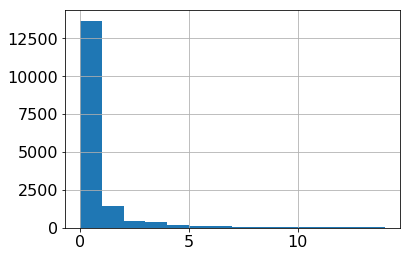

In [12]:
submission_df = pd.merge(submission_df, unique_img_ids)
submission_df['counts'] = submission_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
submission_df['counts'].hist(bins=submission_df['counts'].max())

In [13]:
submission_df.head()

,ImageId,EncodedPixels,counts
0,00002bd58.jpg,NaN,0
1,00015efb6.jpg,NaN,0
2,00023d5fc.jpg,NaN,0
3,000367c13.jpg,286641 1 287408 3 288175 5 288944 3 289713 1,1
4,0008ca6e9.jpg,NaN,0


In [14]:
counts_indices = np.argsort(unique_img_ids['counts'].values)[::-1]

In [15]:
BATCH_SIZE = 64
BATCH_NUM = 0

left = BATCH_NUM*BATCH_SIZE
right = (BATCH_NUM+1)*BATCH_SIZE
# print(left, right)
idx = counts_indices[left:right]
# print(len(idx))
img_ids = unique_img_ids['ImageId'].values[idx]
# print(img_ids)
ship_counts = unique_img_ids['counts'].values[idx]
# print(ship_counts)
ids_counts_dict = {k:v for k, v in zip(img_ids, ship_counts)}


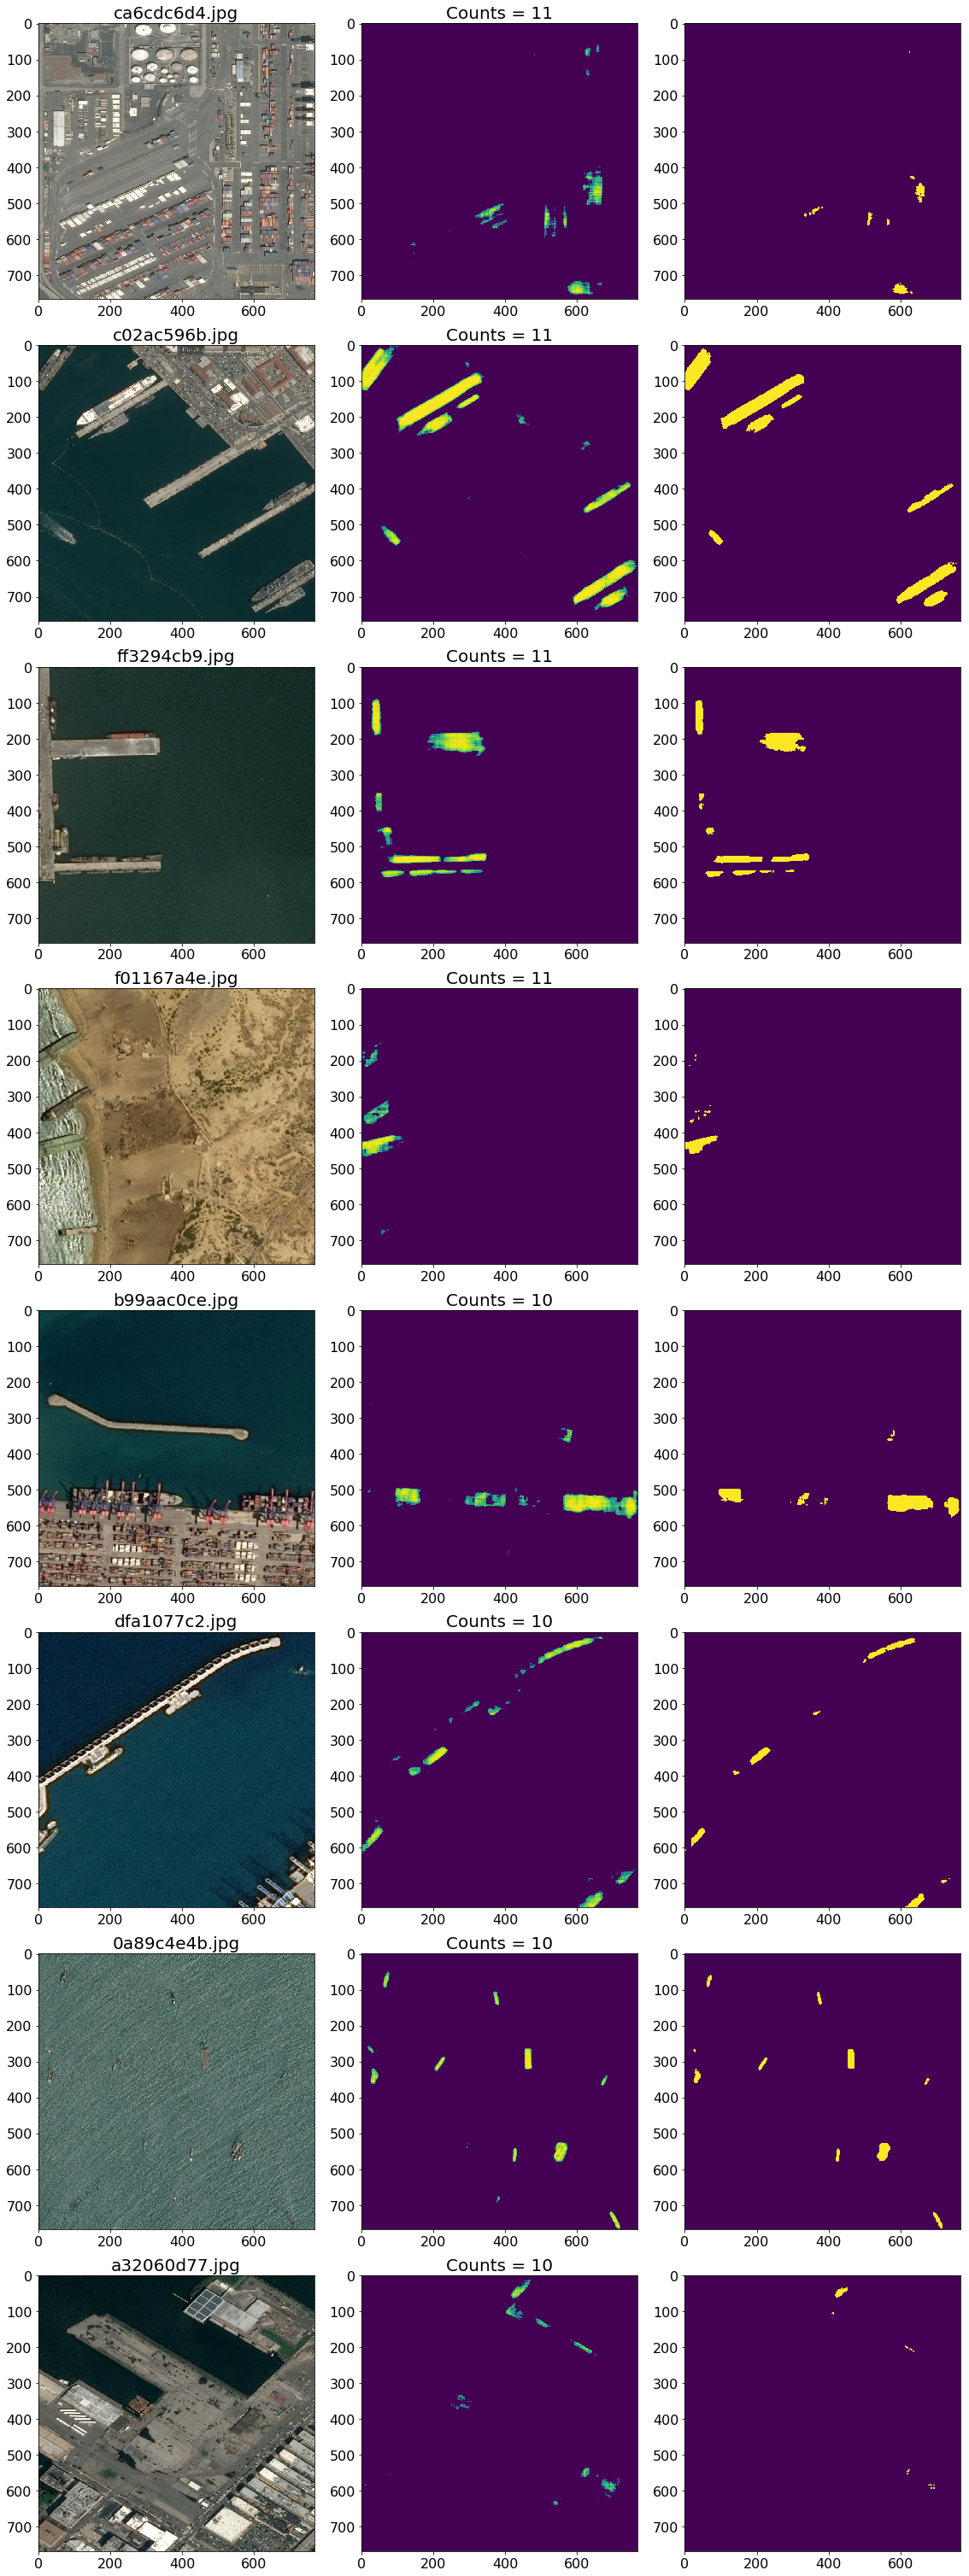

In [16]:
n_samples = 8
aa = 1

test_indices = idx[aa * n_samples: (aa + 1) * n_samples]

fig, m_axs = plt.subplots(n_samples, 3, figsize = (16, 42))
for (ax1, ax2, ax4), c_idx in zip(m_axs, test_indices):
    (c_img_id, c_masks) = all_batches[c_idx]
    c_file = os.path.join(test_image_dir, c_img_id)
    c_img = cv2.cvtColor(cv2.imread(c_file), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    c_seg = seg_model.predict(c_img[None, ...])
#     c_masks = all_batches[c_img_id]
    c_mask = rle_to_full_mask(c_masks['EncodedPixels'].values)
#     cur_seg = binary_opening(c_seg[0] > 0.5, np.expand_dims(disk(2), -1))
#     cur_rles = multi_rle_encode(cur_seg)
#     print(c_mask.shape)
#     break
    ax1.imshow(c_img)
    ax1.set_title(c_img_id)
    ax2.imshow(c_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title(f"Counts = {ids_counts_dict[c_img_id]}")
#     ax3.imshow(cur_seg[..., 0], vmin = 0, vmax = 1)
#     ax3.set_title(f'Pred: {len(cur_rles)}')# {ids_counts_dict[c_img_id]}')
#     ax3.imshow(y_true[..., -1], vmin = 0, vmax = 1)
#     ax3.set_title(f"Truth: ") #"{image_weights.loc[image_weights['ImageId'] == c_img_id, 'counts'].values[0]}")
    ax4.imshow(c_img)
    ax4.imshow(c_mask, vmin = 0, vmax = 1)

plt.tight_layout()
